## Partie 2: Capital Asset Pricing Model (CAPM)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)

Inconvénient de la diversification de Markowitz : le nombre d'estimations nécessaires.

- n estimations de rendements
- n estimations de variances
- $\frac{n^2-n}{2}$ estimations de covariances

Total : $\frac{n^2-n}{2} + 2n$ estimations.

In [2]:
n = 50

print((n ** 2 - n) / 2 + 2 * n)

1325.0


Le single-index model suppose que l'aléa que constitue le rendement considéré est en fait composé de deux éléments !
- une compostante liée au marché
- une composante liée à la spécificité de l'actif par rapport au marché.

On considère le surplus du rendement de l'actif i (par rapport à l'actif sans risque) :
$$R_i = r_i - r_f$$
Avec le surplus de rendement du marché M qui est donné par
$$R_M = r_M - r_f$$

Le modèle prend la forme suivante:
$R_i=$ Composante liée au marché + Composante spécifique

$$R_i = \beta_i * R_M + X_i$$
Avec $\beta_i$ représentant la sensibilité de l'actif au marché. 
On peut décomposer $X_i$ en une composante fixe et une composante aléatoire d'espérance nulle.
$$R_i = \alpha_i + \beta_iR_M + e_i$$

- $\alpha$ est le surplus de rendement hors-marché de l'actif (*nonmarket premium*).
- $\beta$ est la sensibilité de l'actif aux variations du marché (*sensitivity to the market*)
- $e$ est la part de l'aléa spécifique à l'actif.

Il est possible d'estimer les éléments de cette identité à l'aide de données temporelles :
$$R_i(t) = \alpha_i + \beta_iR_M(t) + e_i(t)$$

Si l'on se plie aux hypothèses économétriques du modèle linéaire, notamment la normalité de la composante $e_i(t)$ et l'indépendance des $e_i(t)$, on peut réaliser une régression par les moindres carrés ordinaires. Ces hypothèses sont relativement fortes: il est possible d'en relâcher certaines et de produire des estimations qui sont moins sujettes aux biais liés à la violation des hypothèses. Citons par exemple le generalized autoregressive conditional heteroskedasticity (GARCH) model, qui permet de supposer que les termes d'erreurs (cad la composante spécifique à l'actif) sont corrélés entre eux.

Pour illustrer une régression linéaire, générons des données artificiellement à l'aide de [np.random.normal()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.normal.html) qui permet de générer des nombres selon une loi normale d'espérance 0 et d'écart-type 1.

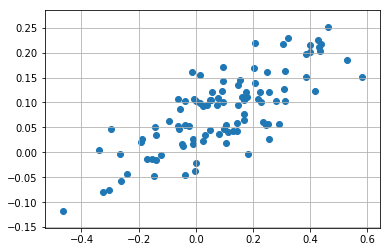

In [3]:
beta_i = 0.3
alpha_i = 0.05
E_R_M = 0.1
sigma_R_M = 0.20
sigma_e_i = 0.05
nb_tirages = 100
liste_R_M = []
liste_R_i = []

for tirage in range(nb_tirages):
    R_M = sigma_R_M * np.random.normal() + E_R_M
    R_i = alpha_i + beta_i * R_M + sigma_e_i * np.random.normal()
    liste_R_M.append(R_M)
    liste_R_i.append(R_i)

plt.scatter(liste_R_M, liste_R_i)
plt.grid(True)

Pour réaliser une régression linéaire, on va se servir du package [StatsModel](http://www.statsmodels.org/stable/index.html).

In [4]:
import statsmodels.api as sm

y = pd.DataFrame({'R_i' : liste_R_i})
X = pd.DataFrame({'R_M' : liste_R_M, 
                  'Constante' : [1] * nb_tirages})
print(X.head())
print(y.head())

model = sm.OLS(y, X).fit()
model.summary()

/home/xubuntu/.local/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


   Constante       R_M
0          1  0.049945
1          1 -0.465999
2          1  0.461120
3          1 -0.339243
4          1  0.167080
        R_i
0  0.104991
1 -0.117720
2  0.251133
3  0.005025
4  0.064643


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    R_i   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     149.1
Date:                Wed, 14 Feb 2018   Prob (F-statistic):           2.12e-21
Time:                        13:26:37   Log-Likelihood:                 160.53
No. Observations:                 100   AIC:                            -317.1
Df Residuals:                      98   BIC:                            -311.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Constante      0.0557      0.005     10.383      0.000       0.045       0.066
R_M            0.2877      0.024     12.213      0.000       0.241       0.334
==============================================================================
Omnibus:                        2.362   Durbin-Watson:                   1.797
Prob(Omnibus):                  0.307   Jarque-Bera (JB):                1.596
Skew:                          -0.036   Prob(JB):                        0.450
Kurtosis:                       2.385   Cond. No.                         4.84
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

On peut obtenir les paramètres du modèles à l'aide de:

In [5]:
model.params

Constante    0.055689
R_M          0.287741
dtype: float64

Et un paramètre en particulier comme suit:

In [6]:
model.params['R_M']

0.287741199632085

On peut représenter la droite estimée sur le diagramme de dispersion:

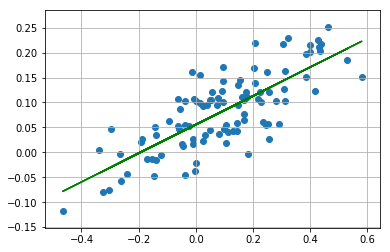

In [7]:
plt.scatter(liste_R_M, liste_R_i)
plt.plot(X['R_M'], model.params['R_M'] * X['R_M'] +  model.params['Constante'], color="Green")
plt.grid(True)

Intéressons-nous à la variance de notre actif i :
$$Var(R_i) = Var(\alpha_i + \beta_iR_M + e_i)$$
$$Var(r_i - r_f) = Var(\alpha_i + \beta_i(r_M - r_f) + e_i)$$
$$\sigma_i^2 = \beta_i^2\sigma_M^2 + \sigma(e_i)^2$$

On peut donc séparer la variance du surplus de rendement en variance due au marché et en variance spécifique à l'actif.

La covariance entre les deux actifs i et j est simplement :
$$Cov(r_i, r_j) = \beta_i\beta_j\sigma_M^2$$
Ce qui nous donne:
$$Corr(r_i, r_j) = \frac{\beta_i\beta_j\sigma_M^2}{\sigma_i\sigma_j} = \frac{\beta_i\sigma_M^2\beta_j\sigma_M^2}{\sigma_i\sigma_M\sigma_j\sigma_M} = Corr(r_i, r_M) * Corr(r_j, r_M)$$

Pour le moment, nous avons beaucoup moins d'estimations requises. 

Il nous faut :
- n estimations des surplus de rendement hors-marché, $\sigma_i$.
- n estimations des sensibilités de l'actif aux variations du marché, $\beta_i$
- n estimations des variances spécifiques à l'actif, $\sigma^2(e_i)$
- 1 estimation du surplus de rendement du marché, $E(R_M)$
- 1 estimation de la variance du marché $\sigma^2_M$


Soit $3n + 2$ estimations.

### Estimation de données réelles

### Construction d'un portefeuille à l'aide du single-index model